In [19]:
#This script performs several setps of time series analyis
# First section: Order selection for ARIMAX model based on lowest AIC and BIC
# Second section: Testing for model performance improvement

# The aim of our research is not to identify multicollinearity, endogeneity, the only purpose is to test in all the following scripts whether the predictive power of two different models can be improved.

import pandas as pd
import numpy as np
import pickle
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
random.seed(42)

df = pd.read_csv("./tsdata/modeldata.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"


train = df[:'2022-01-01']
test = df['2022-01-02':]

In [20]:
#Model fitting
y = train['returns']
X_msci = train[["msci"]]
X_sent = train[["sentiment"]] #"sentiment" is our own sentiment score derived fromt the sentiment LDA
X_both = train[["msci","sentiment"]]#Both the MSCI and the sentiment score are included


ytest = test["returns"]

Xmsci_test = test[["msci"]]
Xsent_test = test[["sentiment"]]
Xboth_test = test[["msci", "sentiment"]]


def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))


def evaluateModel(data, exog, order, actual, exogtest):
    model = SARIMAX(data, exog=exog, order=(order[0], 0, order[1]), enforce_stationarity=True, enforce_invertibility=True)
    model_fit = model.fit(disp=False, maxiter = 300)
    prediction = model_fit.get_forecast(steps=len(ytest), exog=exogtest).predicted_mean
    MAPE_f = mape(actual, prediction)
    RMSE_f = rmse(actual, prediction)
    return order, model_fit.aic, model_fit.bic, MAPE_f, RMSE_f

orders = [(p, q) for p in range(5) for q in range(5) if (p, q) != (0, 0)]

results_base = []
results_msci = []
results_sent = []
results_both = []

#Base model
for order in orders:
    try:
        order, aic, bic, MAPE_base, RMSE_base = evaluateModel(y, None, order, ytest, None)
        results_base.append([order, aic, bic, MAPE_base, RMSE_base])
    except Exception as e:
        print(f"Order {order} for base model failed: {e}")


#Including MSCI
for order in orders:
    try:
        order, aic_msci, bic_msci, MAPE_msci, RMSE_msci = evaluateModel(y, X_msci, order, ytest, Xmsci_test)
        results_msci.append([order, aic_msci, bic_msci, MAPE_msci, RMSE_msci])
    except Exception as e:
        print(f"Order {order} with msci failed: {e}")

#Including own sentiment score
for order in orders:
    try:
        order, aic_sent, bic_sent, MAPE_sent, RMSE_sent = evaluateModel(y, X_sent, order, ytest, Xsent_test)
        results_sent.append([order, aic_sent, bic_sent, MAPE_sent, RMSE_sent])
    except Exception as e:
        print(f"Order {order} with sentiment failed: {e}")


#Including both scores
for order in orders:
    try:
        order, aic_both, bic_both, MAPE_both, RMSE_both = evaluateModel(y, X_both, order, ytest, Xboth_test)
        results_both.append([order, aic_both, bic_both, MAPE_both, RMSE_both])
    except Exception as e:
        print(f"Order {order} with both variables failed: {e}")


df_base = pd.DataFrame(results_base, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_msci = pd.DataFrame(results_msci, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_sent = pd.DataFrame(results_sent, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_both = pd.DataFrame(results_both, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [21]:
basemodel = SARIMAX(y, None, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
basefit = basemodel.fit(disp=False, maxiter = 300)
basefit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  121
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  26.126
Date:                Sun, 21 Apr 2024   AIC                            -46.253
Time:                        12:01:44   BIC                            -37.865
Sample:                    01-01-2012   HQIC                           -42.846
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.37e-05   7.28e+04      0.000       1.000       1.000
ma.L1         -0.9991      0.086    -11.583      0.000      -1.168      -0.830
sigma2         0.0360      0.006      6.109      0.000       0.024       0.048
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                 0.66
Prob(Q):                              0.29   Prob(JB):                         0.72
Heteroskedasticity (H):               2.45   Skew:                            -0.16
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
acorr_ljungbox(basefit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,13.773307,0.183585


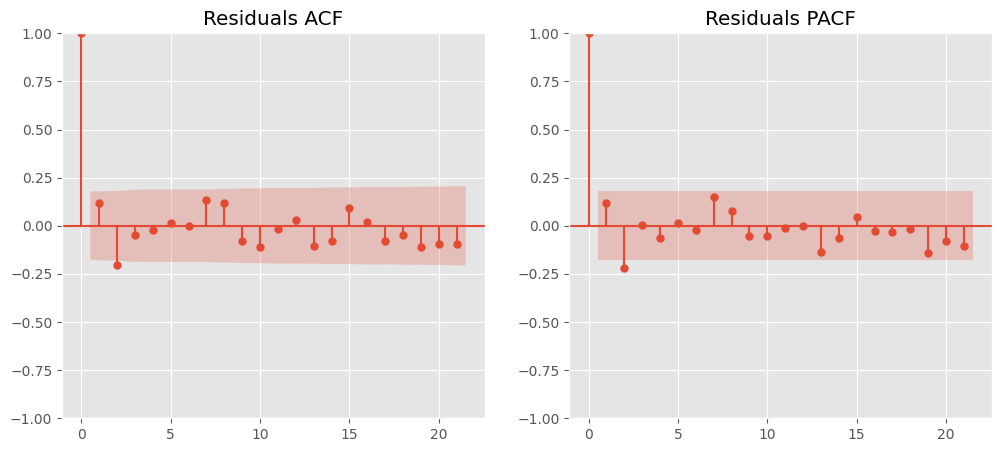

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


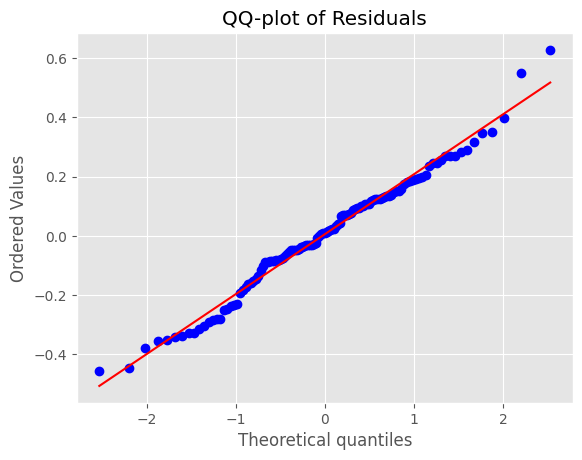

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(basefit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(basefit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(basefit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [24]:
mscimodel = SARIMAX(y, X_msci, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
mscifit = mscimodel.fit(disp=False, maxiter = 300)
mscifit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  121
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  26.225
Date:                Sun, 21 Apr 2024   AIC                            -44.449
Time:                        12:01:45   BIC                            -33.266
Sample:                    01-01-2012   HQIC                           -39.907
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci          -0.0986      0.204     -0.484      0.629      -0.498       0.301
ar.L1          1.0000   5.63e-05   1.78e+04      0.000       1.000       1.000
ma.L1         -0.9988      0.261     -3.830      0.000      -1.510      -0.488
sigma2         0.0360      0.010      3.469      0.001       0.016       0.056
===================================================================================
Ljung-Box (L1) (Q):                   1.13   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.29   Prob(JB):                         0.65
Heteroskedasticity (H):               2.44   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
acorr_ljungbox(mscifit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,13.660168,0.189064


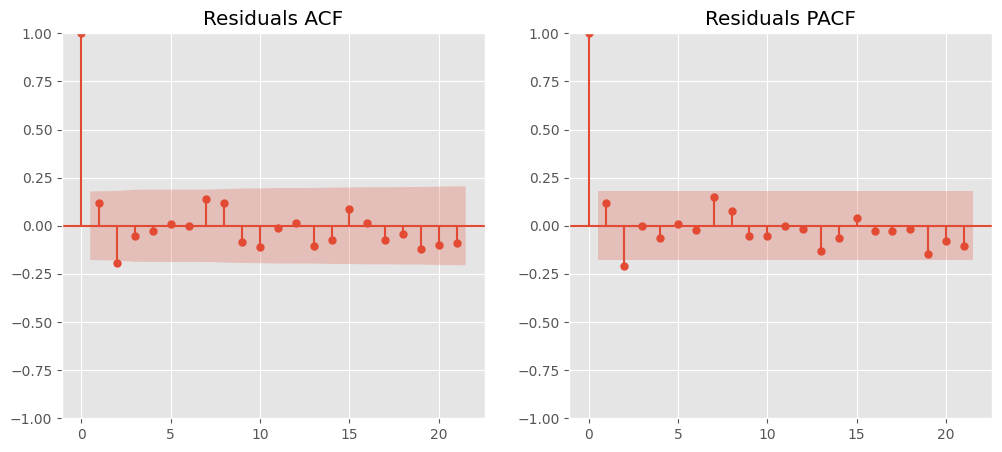

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


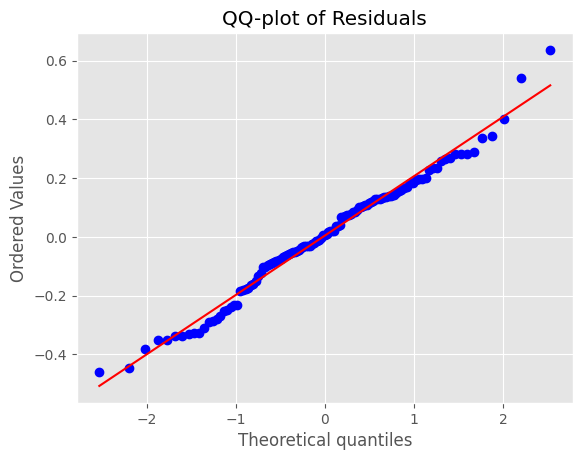

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(mscifit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(mscifit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(mscifit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [27]:
sentmodel = SARIMAX(y, X_sent, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
sentfit = sentmodel.fit(disp=False, maxiter = 300)
sentfit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  121
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  26.135
Date:                Sun, 21 Apr 2024   AIC                            -44.270
Time:                        12:01:45   BIC                            -33.087
Sample:                    01-01-2012   HQIC                           -39.728
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment      0.0097      0.071      0.136      0.892      -0.130       0.149
ar.L1          1.0000    6.8e-05   1.47e+04      0.000       1.000       1.000
ma.L1         -0.9987      0.282     -3.537      0.000      -1.552      -0.445
sigma2         0.0361      0.011      3.356      0.001       0.015       0.057
===================================================================================
Ljung-Box (L1) (Q):                   1.09   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.30   Prob(JB):                         0.73
Heteroskedasticity (H):               2.44   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
acorr_ljungbox(sentfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,13.744731,0.184957


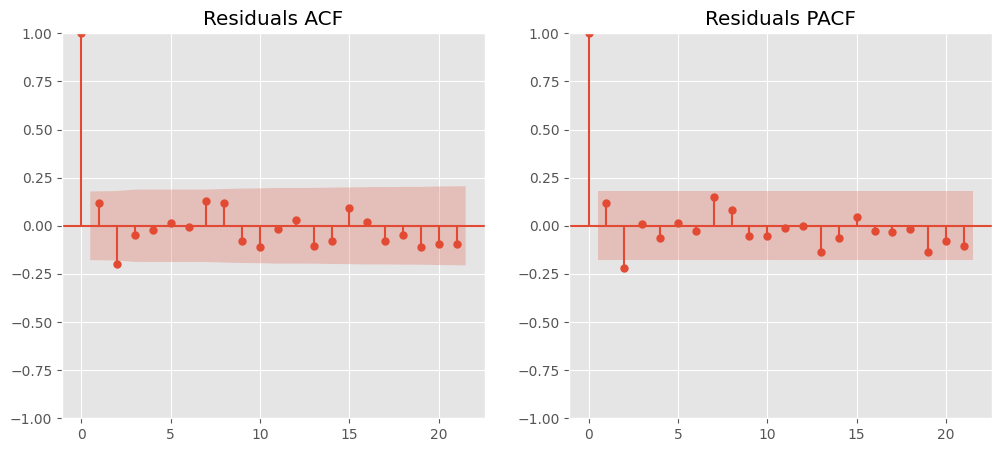

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


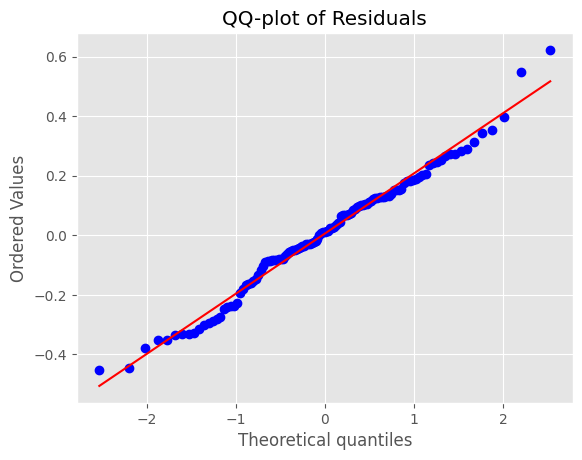

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(sentfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(sentfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(sentfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [30]:
bothmodel = SARIMAX(y, X_both, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
bothfit = bothmodel.fit(disp=False, maxiter = 300)
bothfit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                  121
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  26.239
Date:                Sun, 21 Apr 2024   AIC                            -42.478
Time:                        12:01:46   BIC                            -28.499
Sample:                    01-01-2012   HQIC                           -36.801
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci          -0.1011      0.205     -0.492      0.623      -0.503       0.301
sentiment      0.0120      0.070      0.173      0.863      -0.124       0.148
ar.L1          1.0000   2.34e-06   4.27e+05      0.000       1.000       1.000
ma.L1         -0.9993      0.020    -49.270      0.000      -1.039      -0.960
sigma2         0.0360      0.005      7.087      0.000       0.026       0.046
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.30   Prob(JB):                         0.66
Heteroskedasticity (H):               2.42   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
acorr_ljungbox(bothfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,13.610064,0.191532


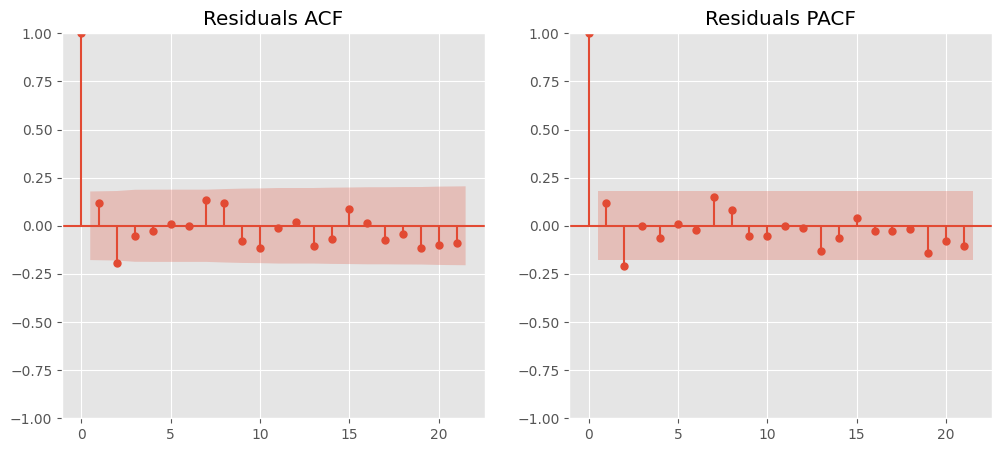

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


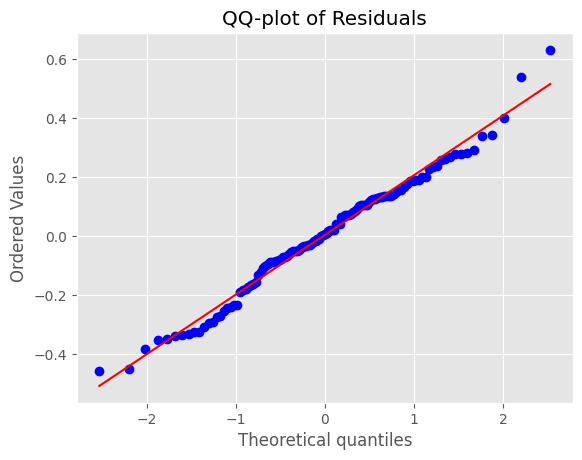

In [32]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(bothfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(bothfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(bothfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [33]:
pbase = basefit.get_forecast(steps=len(ytest), exog=None).predicted_mean
pmsci = mscifit.get_forecast(steps=len(ytest), exog=Xmsci_test).predicted_mean
psent = sentfit.get_forecast(steps=len(ytest), exog=Xsent_test).predicted_mean
pboth = bothfit.get_forecast(steps=len(ytest), exog=Xboth_test).predicted_mean

errors = {
    'Model': ['Base', 'MSCI', 'Sentiment', 'Both'],
    'MAPE': [mape(ytest, pbase), mape(ytest, pmsci), mape(ytest, psent), mape(ytest, pboth)],
    'RMSE': [rmse(ytest, pbase), rmse(ytest, pmsci), rmse(ytest, psent), rmse(ytest, pboth)]
}

results_df = pd.DataFrame(errors)
print(results_df)

       Model        MAPE      RMSE
0       Base  200.287774  0.269401
1       MSCI  199.543792  0.269516
2  Sentiment  200.494490  0.269293
3       Both  199.764295  0.269385


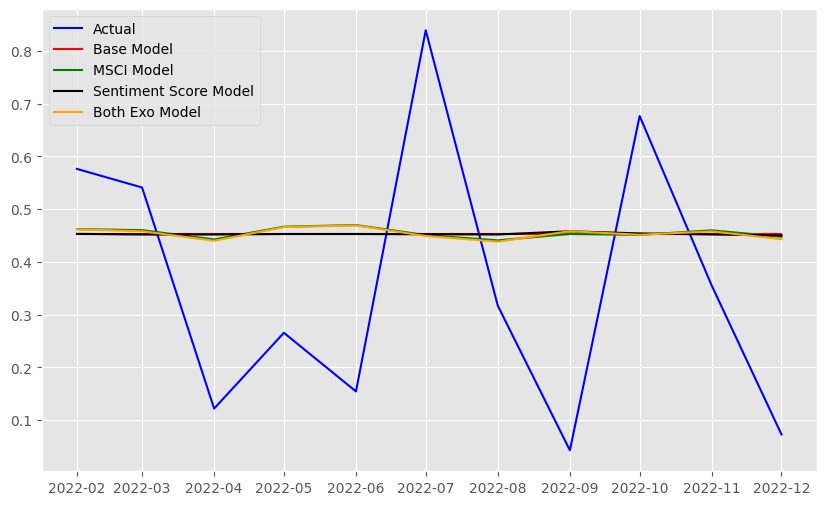

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, ytest, label='Actual', color='blue')
plt.plot(test.index, pbase, label='Base Model', color='red')
plt.plot(test.index, pmsci, label='MSCI Model', color='green')
plt.plot(test.index, psent, label='Sentiment Score Model', color='black')
plt.plot(test.index, pboth, label='Both Exo Model', color='orange')
plt.legend()

In [35]:
portfolio = pd.read_csv("./tsdata/portfolio.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"
log_returns = np.log(portfolio["0"] / portfolio["0"].shift(1)).dropna()

p_train = portfolio[:'2022-01-01']
p_test = portfolio['2022-01-02':]

with open("scaler_returns.pkl", 'rb') as file:
    scaler = pickle.load(file)

predictions = pd.DataFrame()
predictions["Base"]= pbase.values
predictions["Msci"]= pmsci.values
predictions["Sent"]= psent.values
predictions["Both"]= pboth.values

logret_pred = pd.DataFrame()
logret_pred["Base"] = np.exp(scaler.inverse_transform(predictions["Base"].values.reshape(-1, 1)).flatten())
logret_pred["Msci"] = np.exp(scaler.inverse_transform(predictions["Msci"].values.reshape(-1, 1)).flatten())
logret_pred["Sent"] = np.exp(scaler.inverse_transform(predictions["Sent"].values.reshape(-1, 1)).flatten())
logret_pred["Both"] = np.exp(scaler.inverse_transform(predictions["Both"].values.reshape(-1, 1)).flatten())


def generate_portfolio_series(base_price, returns):
    series = [base_price]
    for r in returns:
        series.append(series[-1] * r)
    return series

portfolio_series_df = pd.DataFrame()
portfolio_series_df['Base'] = generate_portfolio_series(p_test.iloc[0], logret_pred["Base"].values)
portfolio_series_df['Msci'] = generate_portfolio_series(p_test.iloc[0], logret_pred["Msci"].values)
portfolio_series_df['Sent'] = generate_portfolio_series(p_test.iloc[0], logret_pred["Sent"].values)
#portfolio_series_df['Both'] = generate_portfolio_series(p_test.iloc[0], logret_pred["Both"].values)
portfolio_series_df.drop(portfolio_series_df.tail(1).index,inplace=True)
portfolio_series_df.index = test.index
portfolio_series_df["Actual"] = p_test

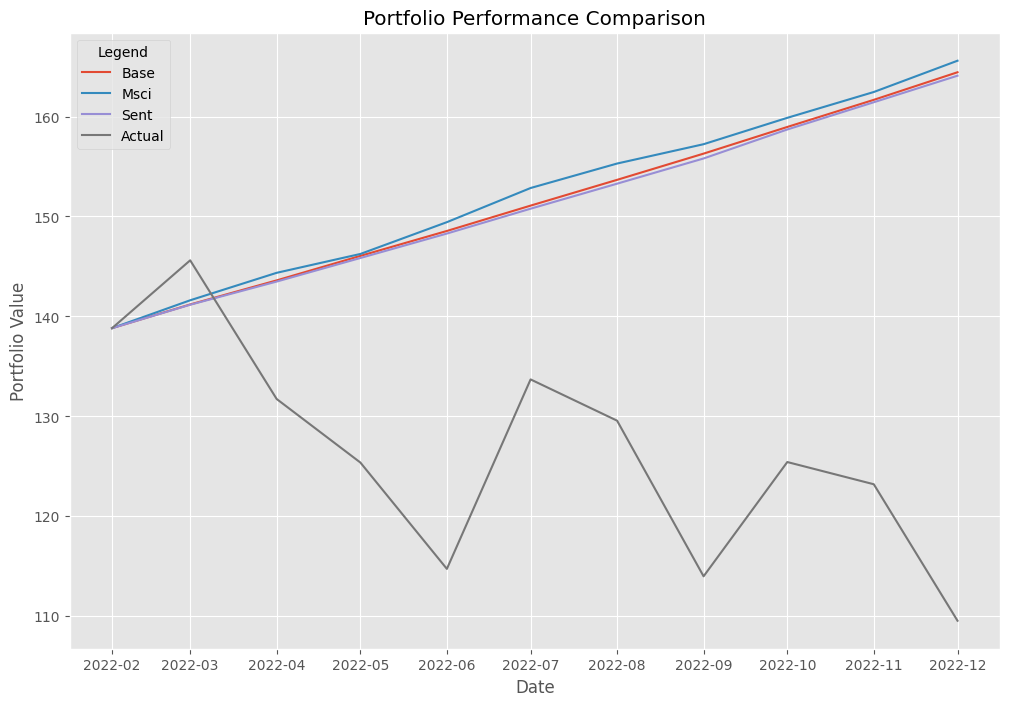

In [36]:

plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

for column in portfolio_series_df.columns:
    plt.plot(portfolio_series_df.index, portfolio_series_df[column], label=column)

plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(title='Legend')
plt.grid(True)

plt.show()
